# OVERVIEW

This iPython Notebook uses the **_Boston Housing_** data set to illustrate

- **Decision Trees** and trees-related **_ensemble modeling_** methods:
- **Random Forests**, which are based on **Bootstrap Aggregating** ("**Bagging**") applied to trees; and 
- **Boosted Additive (Trees) Models**.

# _first, some boring logistics..._

Let's first import some necessary Python packages and helper modules, and set the random number generator's seed:

In [104]:
# enable In-Line MatPlotLib
%matplotlib inline

In [105]:
# import:
from ggplot import aes, geom_line, geom_point, ggplot, ggtitle, xlab, ylab
from matplotlib.pyplot import scatter, title
from multiprocessing import cpu_count
from numpy import log, nan, sqrt
from os import system
from pandas import DataFrame, melt, read_csv
from random import seed
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

system('pip install --upgrade git+git://GitHub.com/ChicagoBoothML/Helpy --no-dependencies')
from ChicagoBoothML_Helpy.CostFunctions import mse

RANDOM_SEED = 99
seed(RANDOM_SEED)

# Boston Housing data set

Let's now import the Boston Housing data into a **`pandas`** data frame:

In [106]:
# read Boston Housing data into data frame
boston_housing = read_csv(
    'https://raw.githubusercontent.com/ChicagoBoothML/DATA___BostonHousing/master/BostonHousing.csv')
boston_housing.sort(columns='lstat', inplace=True)
nb_samples = len(boston_housing)
boston_housing

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
161,1.46336,0.0,19.58,0,0.6050,7.489,90.8,1.9709,5,403,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1,0.6050,7.802,98.2,2.0407,5,403,14.7,389.61,1.92,50.0
40,0.03359,75.0,2.95,0,0.4280,7.024,15.8,5.4011,3,252,18.3,395.62,1.98,34.9
232,0.57529,0.0,6.20,0,0.5070,8.337,73.3,3.8384,8,307,17.4,385.91,2.47,41.7
192,0.08664,45.0,3.44,0,0.4370,7.178,26.3,6.4798,5,398,15.2,390.49,2.87,36.4
204,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.1180,4,224,14.7,390.55,2.88,50.0
3,0.03237,0.0,2.18,0,0.4580,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
370,6.53876,0.0,18.10,1,0.6310,7.016,97.5,1.2024,24,666,20.2,392.05,2.96,50.0
195,0.01381,80.0,0.46,0,0.4220,7.875,32.0,5.6484,4,255,14.4,394.23,2.97,50.0
275,0.09604,40.0,6.41,0,0.4470,6.854,42.8,4.2673,4,254,17.6,396.90,2.98,32.0


# Models with 1 Predictor

For illustrative purposes, let's look at two variables of interest: **`lstat`** (our predictor variable(s) $\mathbf X$) and **`medv`** (our variable to predict $\mathbf y$). Below is a plot of them against each other:

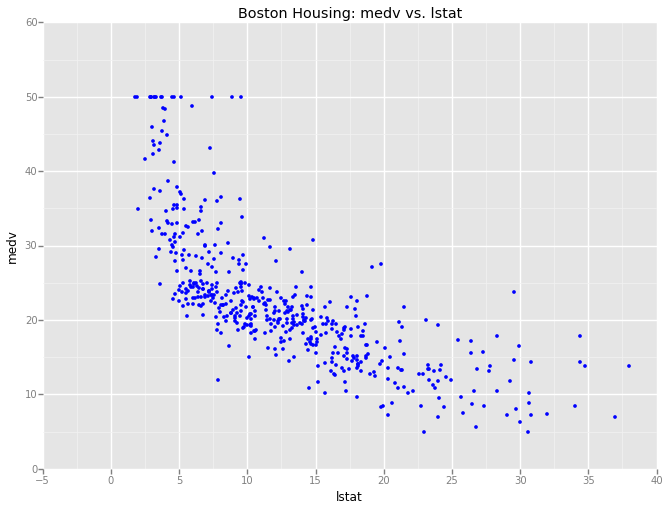

<ggplot: (39192755)>

In [107]:
def plot_boston_housing_data(boston_housing_data,
                             x_name='lstat', y_name='medv', y_hat_name='predicted_medv',
                             title='Boston Housing: medv vs. lstat',
                             plot_predicted=True):
    g = ggplot(aes(x=x_name, y=y_name), data=boston_housing_data) +\
        geom_point(size=10, color='blue') +\
        ggtitle(title) +\
        xlab(x_name) + ylab(y_name)
    if plot_predicted:
        g += geom_line(aes(x=x_name, y=y_hat_name), size=2, color='darkorange')
    return g

plot_boston_housing_data(boston_housing, plot_predicted=False)

## Single Decision Trees

Let's now play with a few single decision trees, using all samples:

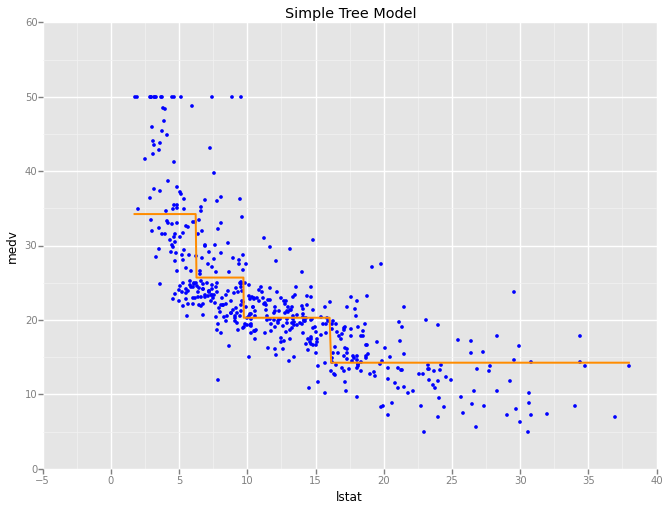

<ggplot: (35725853)>

In [108]:
tree_model = DecisionTreeRegressor(
    criterion='mse',
    splitter='best',
    max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    min_samples_split=200,
    min_samples_leaf=100,
    min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    random_state=RANDOM_SEED)

tree_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)
boston_housing['predicted_medv'] = tree_model.predict(boston_housing[['lstat']])

plot_boston_housing_data(boston_housing, title='Simple Tree Model')

We see that with the above tuning parameters, the tree model is a **fairly simple, crude step function**. This function seems to have **high bias** and **low variance**.

Let's try bigger, more complex tree:

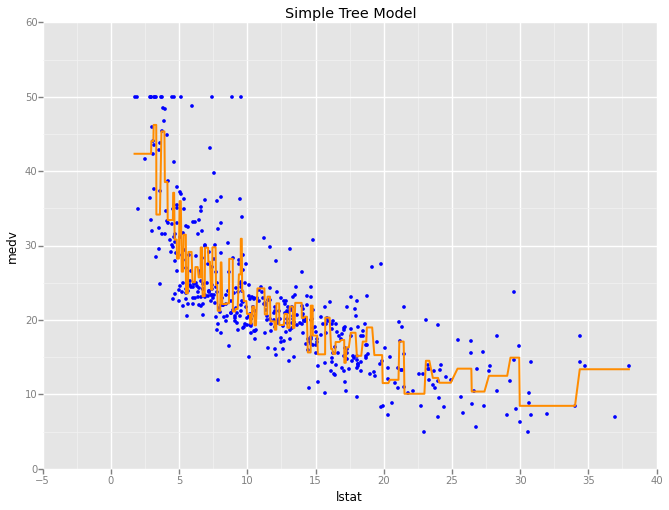

<ggplot: (32583225)>

In [109]:
tree_model = DecisionTreeRegressor(
    criterion='mse',
    splitter='best',
    max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    min_samples_split=10,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    random_state=RANDOM_SEED)

tree_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)
boston_housing['predicted_medv'] = tree_model.predict(boston_housing[['lstat']])

plot_boston_housing_data(boston_housing, title='Simple Tree Model')

Now, with the new parameters, we have a more complex model that is **low-bias**, **high-variance**.

Fitting a good model with a single tree is difficult, largely because a single tree is fit using a greedy heuristic that may not be optimal in the first place.

In practice, trees are almost always used in an **ensemble modeling** manner. The computational inexpensiveness of individual trees allow numerous trees to be fitted in acceptable run times, and collected into an "ensemble" of fitted models, the predictions of which are combined in certain ways. Two prominent ensemble methods are **bagging** (**_bootstrap aggregating_**) and **boosting**.

## Bagging and Random Forests

With the [**bagging**](http://en.wikipedia.org/wiki/Bootstrap_aggregating) method, $B$ models of a certain kind (usually, but not necessarily, tree models) are fitted on $B$ bootstrap samples of the training data set, and their **predictions are averaged** to produce the ensemble prediction function.

- Each **individual model** among the $B$ model should be a **sufficiently-complex, low-bias** model &ndash; which also means that each individual model is likely to have **high variance**;
- The low bias of each model will result in an **average ensemble model that also has low bias**; and
- In order to make the ensemble model also have low variance, we select a large enough number $B$, so that individual models' high variances offset each other in the aggregate!

The application of "bagging" using tree models is called **Random Forest**:

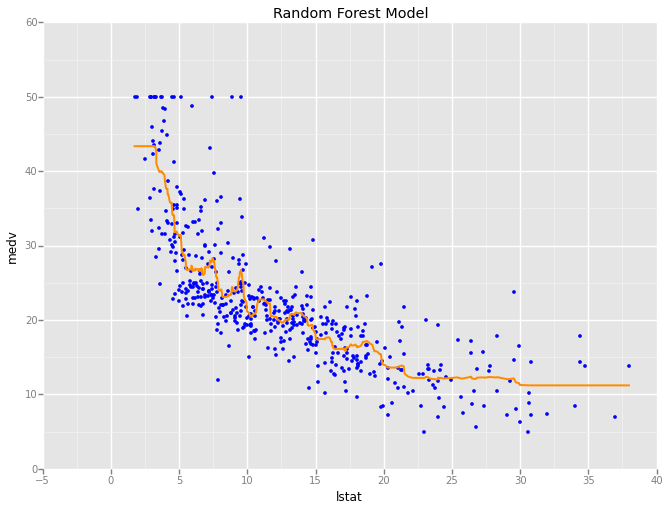

<ggplot: (32854413)>

In [110]:
B = 5000

rf_model = RandomForestRegressor(
    n_estimators=B,
    criterion='mse',
    max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    min_samples_split=20,
    min_samples_leaf=10,
    min_weight_fraction_leaf=0.0,
    max_features='auto',   # number of features to consider when looking for the best split; "auto": max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag RMSE
    n_jobs=cpu_count() - 2,   # paralellize over all CPU cores but 2
    random_state=RANDOM_SEED,
    verbose=0,
    warm_start=False)

rf_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)
boston_housing['predicted_medv'] = rf_model.predict(boston_housing[['lstat']])

plot_boston_housing_data(boston_housing, title='Random Forest Model')

We can see that the average prediction of many trees in the Random Forest does well in capturing the signal in the data. We'd be reasonably happy with such a predictive model. The estimated Out-of-Bag (OOB) RMSE of this model is:

In [111]:
# note that the "oob_score_" provided by SciKit is the estimated Out-of-Bag R^2
# from R^2 we can derive a rough RMSE
sqrt(boston_housing['medv'].var() * (1 - rf_model.oob_score_))

5.3780034148479157

## Boosting

With the <a href="http://en.wikipedia.org/wiki/Boosting_(machine_learning)">**boosting**</a> method, we successively advance towards a good model fit by adding up small fractions / proportions of relatively simple models that have low variances but possibly high biases. The key intuition is as follows:

- Because individual models are simple and have low variance, the combined additive ensemble model is also likely to have low variance; and
- Because models are successively fit to capture the residuals left over from the previous models, models' biases are likely to offset each other, resulting in an additive ensemble model with low bias!

Let's now build a tree ensemble using boosting:

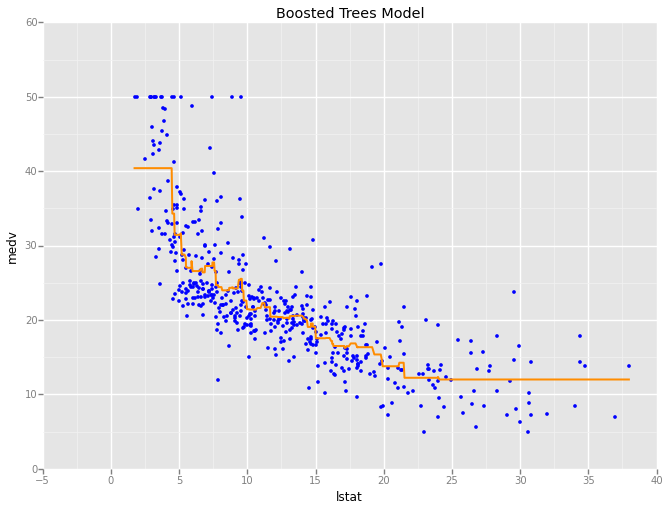

<ggplot: (38736136)>

In [112]:
boost_model = GradientBoostingRegressor(
    n_estimators=B,
    loss='ls',   # Least-Squares objective loss function
    learning_rate=.001,   # shrinkage parameter
    subsample=1.0,
    min_samples_split=80,
    min_samples_leaf=40,
    min_weight_fraction_leaf=0.0,
    max_depth=10,   # maximum tree depth / number of levels of interaction
    init=None,
    random_state=RANDOM_SEED,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    alpha=0.9,   # NOT RELEVANT for Least-Squares loss function
    verbose=0,
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    warm_start=False)

boost_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)
boston_housing['predicted_medv'] = boost_model.predict(boston_housing[['lstat']])

plot_boston_housing_data(boston_housing, title='Boosted Trees Model')

This Boosted Trees ensemble model also looks fair, and its OOS RSME can be estimated using Cross Validation as follows:

In [113]:
def mse_score(estimator, X, y):
    y_hat = estimator.predict(X)
    return mse(y_hat, y)

sqrt(cross_val_score(
        boost_model,
        X=boston_housing[['lstat']],
        y=boston_housing.medv,
        cv=KFold(n=nb_samples,
                 n_folds=5,   # 5-fold cross validation
                 shuffle=True),
        scoring=mse_score).mean())

5.4061057271712789

# Multivariate Models

Besides their computation inexpensiveness, another _huge_ advantage of using trees-based algorithms is that they are very scalable to multivariate models, and deals with variable interactions very nicely without the need of standard scaling.

Let's build multivariate Random Forest and Boosted Trees models to predict _medv_ using all other variables in the Boston Housing data set:

In [114]:
boston_housing.drop('predicted_medv', axis=1, inplace=True)   # remove predicted values column

In [115]:
nb_columns = len(boston_housing.columns)
X_column_names = boston_housing.columns[:(nb_columns - 1)]

In [116]:
rf_model.fit(X=boston_housing[X_column_names], y=boston_housing.medv)
rf_predictions = rf_model.predict(boston_housing[X_column_names])

The multivariate Random Forest has an estimated OOB RMSE of:

In [117]:
sqrt(boston_housing['medv'].var() * (1 - rf_model.oob_score_))

3.9317592863722752

which is clearly better than that of the univariate Random Forest model.

In [118]:
boost_model.fit(X=boston_housing[X_column_names], y=boston_housing.medv)
boost_predictions = boost_model.predict(boston_housing[X_column_names])

The multivariate Boosted Trees model has an estimated Cross Validation-estimated OOS RMSE of:

In [119]:
sqrt(cross_val_score(
        boost_model,
        X=boston_housing[X_column_names],
        y=boston_housing.medv,
        cv=KFold(n=nb_samples,
                 n_folds=5,   # 5-fold cross validation
                 shuffle=True),
        scoring=mse_score).mean())

3.9768890121796576

again a clear improvement from the univariate Boosted Trees model.

We can also see that the two models' prediction are pretty aligned:

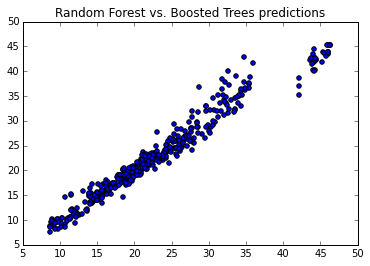

In [120]:
scatter(rf_predictions, boost_predictions)
title('Random Forest vs. Boosted Trees predictions')

The two models also agree on the most important variables:

In [121]:
feature_importances = DataFrame(index=X_column_names)
feature_importances['RandomForest_VarImp'] = rf_model.feature_importances_
feature_importances['BoostedTrees_VarImp'] = boost_model.feature_importances_
feature_importances

,RandomForest_VarImp,BoostedTrees_VarImp
crim,0.028760,0.035551
zn,0.000472,0.000013
indus,0.002505,0.009487
chas,0.000030,0.000000
nox,0.016513,0.086986
rm,0.473040,0.224030
age,0.009453,0.033198
dis,0.015360,0.162538
rad,0.002399,0.015372
tax,0.005606,0.035650
